# Visualization of Stock Trading

In [1]:
# import libraries
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns

## Set relevant parameters

In [2]:
train_stock = 'data/MGLU3/MGLU3.csv'
val_stock = 'data/MGLU32019/MGLU32019.csv'
window_size = 10
batch_size = 16
ep_count = 10
model_name = 'model_ep1000'
pretrained = False
debug = False

## Load Dataset into pandas DataFrame

In [3]:
# read csv into dataframe
df = pd.read_csv(val_stock)

# filter out the desired features
df = df[['data_pregao', 'preco_ultimo_negocio']]

# rename feature column names
df = df.rename(columns={'Adj Close': 'preco_ultimo_negocio', 'Date': 'data_pregao'})

df.head()

data_pregao  preco_ultimo_negocio
0  2019-01-02                185.99
1  2019-01-03                184.00
2  2019-01-04                178.40
3  2019-01-07                181.17
4  2019-01-08                179.71

In [4]:
# convert dates from object to DateTime type
dates = df['data_pregao']
dates = pd.to_datetime(dates, infer_datetime_format=True)
df['data_pregao'] = dates

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 2 columns):
data_pregao             236 non-null datetime64[ns]
preco_ultimo_negocio    236 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.8 KB


data_pregao  preco_ultimo_negocio
0  2019-01-02                185.99
1  2019-01-03                184.00
2  2019-01-04                178.40
3  2019-01-07                181.17
4  2019-01-08                179.71

## Visualization of actions taken by Trading Bot

In [11]:
def visualize(df, history):
    # add history to dataframe
    position = [history[0][0]] + [x[0] for x in history]
    actions = ['HOLD'] + [x[1] for x in history]
    df['position'] = position
    df['action'] = actions
    
    # specify y-axis scale for stock prices
    scale = alt.Scale(domain=(min(min(df['actual']), min(df['position'])) - 50, max(max(df['actual']), max(df['position'])) + 50), clamp=True)
    
    # plot a line chart for stock positions
    actual = alt.Chart(df).mark_line(
        color='green',
        opacity=0.5
    ).encode(
        x='date:T',
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale)
    ).interactive(
        bind_y=False
    )
    
    # plot the BUY and SELL actions as points
    points = alt.Chart(df).transform_filter(
        alt.datum.action != 'HOLD'
    ).mark_point(
        filled=True
    ).encode(
        x=alt.X('date:T', axis=alt.Axis(title='Date')),
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale),
        color='action'
        #color=alt.Color('action', scale=alt.Scale(range=['blue', 'red']))
    ).interactive(bind_y=False)

    # merge the two charts
    chart = alt.layer(actual, points, title=val_stock).properties(height=300, width=1000)
    
    return chart

## Training the model

In [14]:
import logging
import coloredlogs

from train import *
from evaluate import show_eval_result

coloredlogs.install(level='DEBUG')
switch_k_backend_device()

agent = Agent(window_size, pretrained=pretrained, model_name=model_name)
train_data = get_stock_data(train_stock)
val_data = get_stock_data(val_stock)

initial_offset = val_data[1] - val_data[0]

for i in range(1, ep_count + 1):
    train_result = train_model(agent, i, train_data, ep_count=ep_count,
                                batch_size=batch_size, window_size=window_size)
    val_result, _ = evaluate_model(agent, val_data, window_size, debug)
    show_train_result(train_result, val_result, initial_offset)

2019-12-11 15:54:50JPAD231923root[26380]DEBUGswitching to TensorFlow for CPU


KeyError: 'Adj Close'

## Plotting the evaluation actions

2018-12-31 18:30:34 ubuntu root[32111] INFO model_GOOGL: +$517.44



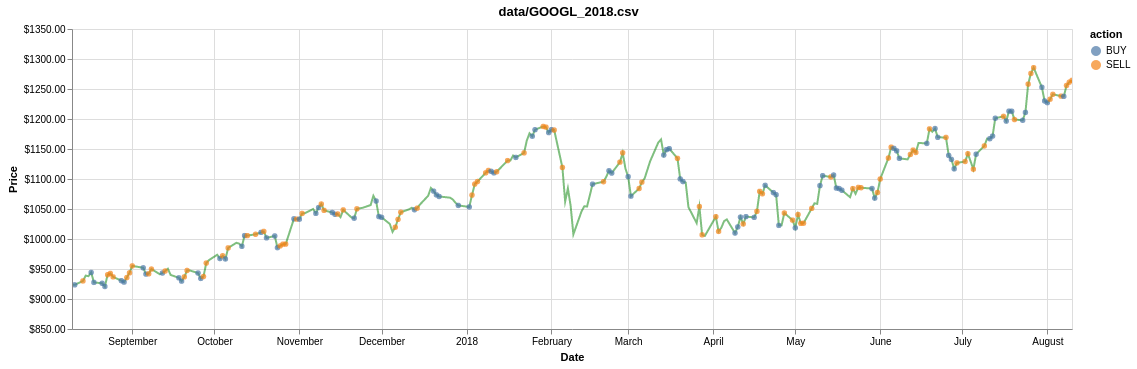

In [80]:
val_result, history = evaluate_model(agent, val_data, window_size, debug)
show_eval_result(model_name, val_result, initial_offset)
chart = visualize(df, history)
chart